**Before you start**<br>
Change runtime type to GPU <br>
Runtime > Change runtime type > GPU > Save

In [1]:
!gdown --id 1Gkn4tCv6Yn6dFHWflRVun08VRPv7MwLi

Downloading...
From: https://drive.google.com/uc?id=1Gkn4tCv6Yn6dFHWflRVun08VRPv7MwLi
To: /content/training_data.zip
100% 57.1M/57.1M [00:00<00:00, 70.1MB/s]


In [2]:
!unzip -qq /content/training_data.zip

In [3]:
# install fastai
!pip install -Uqq fastbook
from fastai.vision.all import *

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 34.7 MB/s 
     |████████████████████████████████| 186 kB 45.6 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 290 kB/s 


In [4]:
# Point script at data
path = Path('/content/training data')
path

Path('/content/training data')

In [5]:
# define model name
model_name = 'cloud_model'

In [6]:
# make sure things look correct
path.ls()

(#2) [Path('/content/training data/cloud'),Path('/content/training data/no_cloud')]

In [7]:
# set model settings
batch_size = 4
img_size = 500

In [8]:
# define image transforms
item_tfms = [Resize(img_size)]
batch_tfms = [Normalize.from_stats(*imagenet_stats),
            *aug_transforms(size=img_size, flip_vert=True,max_rotate=90.0,max_lighting=0.1,
                            min_zoom=0.8, max_zoom=1.3, max_warp=0,                             
                            )]


In [9]:
# load data
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,splitter=RandomSplitter(seed=42),
                                    bs=batch_size,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms
                                   )


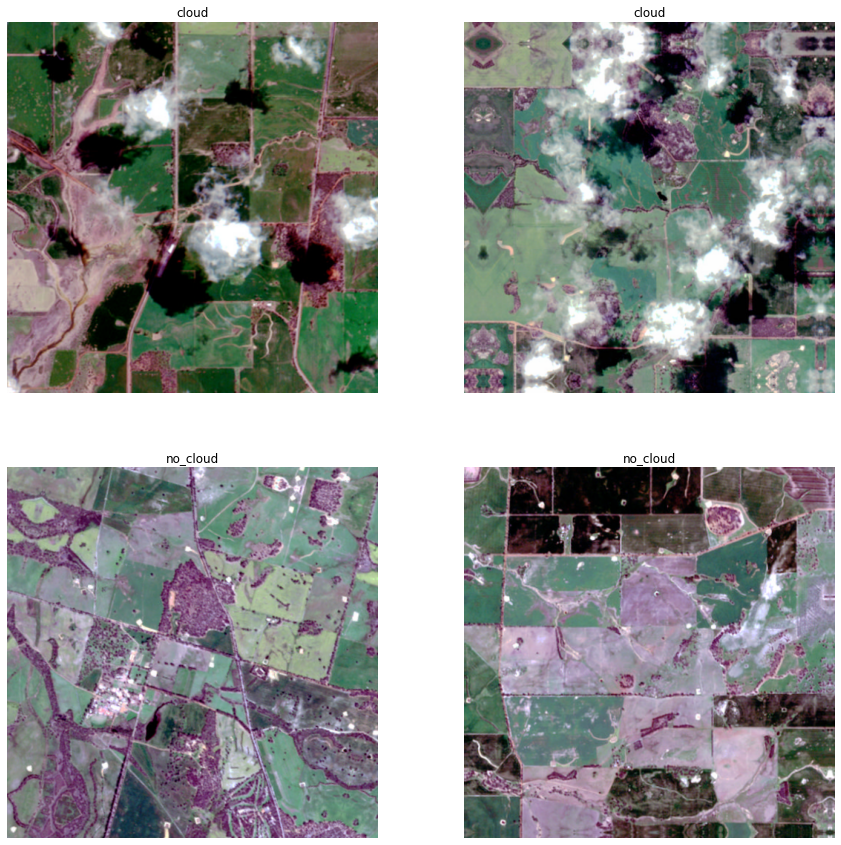

In [10]:
# check data
data.show_batch(max_n = 9, figsize = (15,15))

In [11]:
# save classes to txt file
np.savetxt(path/'classes.csv', np.array(data.vocab), fmt='%s')

In [12]:
# make model
learn = cnn_learner(data, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.520006,0.010341,0.000000,00:20


Better model found at epoch 0 with error_rate value: 0.0.


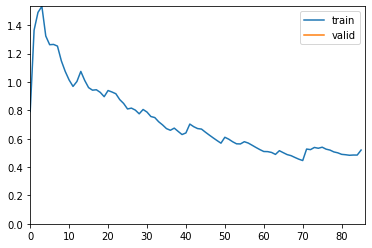

epoch,train_loss,valid_loss,error_rate,time
0,0.557948,0.170238,0.070588,00:21
1,0.407999,0.021856,0.011765,00:21
2,0.498142,0.008820,0.000000,00:21


Better model found at epoch 0 with error_rate value: 0.07058823853731155.


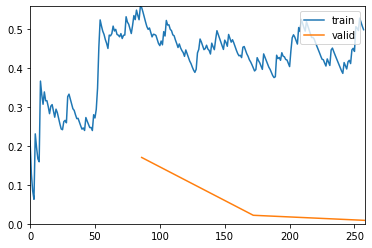

Better model found at epoch 1 with error_rate value: 0.0117647061124444.
Better model found at epoch 2 with error_rate value: 0.0.


In [13]:
# train model
learn.fine_tune(3,cbs = [ShowGraphCallback(),
                         SaveModelCallback(monitor='error_rate',with_opt=True, fname=model_name)])


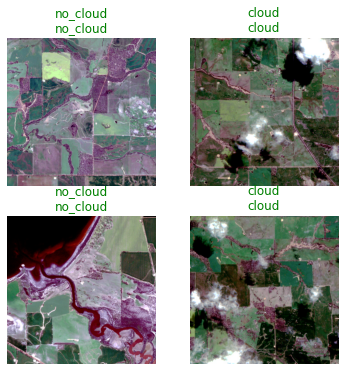

In [14]:
# check the outputs
learn.show_results()

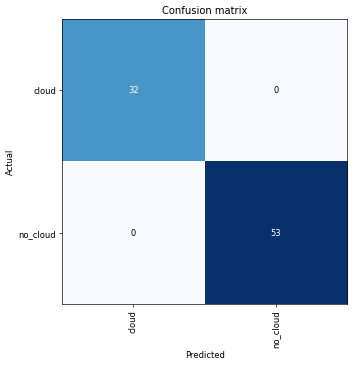

In [15]:
# check confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [16]:
# export model to disk
learn.export('models/'+model_name+'.pkl')

# Infernce

In [17]:
# install some GIS tools
!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 6.3 MB 29.8 MB/s 
     |████████████████████████████████| 15.4 MB 42 kB/s 
     |████████████████████████████████| 19.3 MB 116 kB/s 


In [18]:
# import more tools
# GIS
import geopandas as gpd
import rasterio
from shapely.geometry import box
# system
from multiprocessing import Pool
from tqdm.auto import tqdm

In [19]:
!gdown --id 1uzKfIzm0su1oVzDxkqIdZXU1JMLlp2rf

Downloading...
From: https://drive.google.com/uc?id=1uzKfIzm0su1oVzDxkqIdZXU1JMLlp2rf
To: /content/Inference_data.zip
100% 191M/191M [00:02<00:00, 82.0MB/s]


In [22]:
!unzip -qq /content/Inference_data.zip

replace 202109050217_S2B_MSI_ESA_50HNH_432_chunks/part_100_202109050217_S2B_MSI_ESA_50HNH_432.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
# point this at the tiled data
input_raster_path = '/content/202109100217_S2A_MSI_ESA_50HNH_432_chunks'
# this is the output file path
export_vector_path = input_raster_path+'.gpkg'
export_vector_path

'/content/202109100217_S2A_MSI_ESA_50HNH_432_chunks.gpkg'

In [24]:
# read calsses from text file
classes = np.loadtxt(path/'classes.csv',delimiter='\n', dtype=str)
classes

array(['cloud', 'no_cloud'], dtype='<U8')

In [25]:
# find all files and grab the CRS of one of them
input_rasters = []

for root, dirs, files in os.walk(input_raster_path):
    for file in files:
        if file.endswith('.tif'):
            input_rasters.append(os.path.join(root, file))

dataset = rasterio.open(input_rasters[0])
crs = dataset.crs
            
print('File count',len(input_rasters))
print('CRS',crs)

File count 729
CRS EPSG:3857


In [26]:
# load model setup up data and pushes to GPU
learn_inf = load_learner(path/str('models/'+model_name+'.pkl'))
learn_inf.dls.cuda()
dl = learn_inf.dls.test_dl(input_rasters,device='cuda',bs=batch_size)

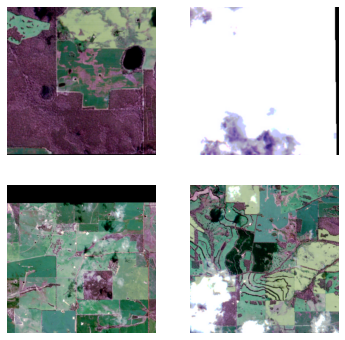

In [27]:
# display a batch
dl.show_batch()

In [28]:
# run model
pred_scores,none,pred_class_int = learn_inf.get_preds(dl=dl,with_decoded=True)

In [29]:
pred_class_int

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [30]:
# use rasterio to open every raster and extract its extent
def get_bounds(raster):
    try:
        dataset = rasterio.open(raster)
        bounds = dataset.bounds
        geom = box(*bounds)
    except:
        print(raster)
    return geom

In [31]:
# loop over data and save into list as dict
pred_dict_list = []
for pred_int,file_path,pred_score in zip(pred_class_int,input_rasters,pred_scores.cpu().detach().numpy()):
#     build dict for each image
    pred_dict = {'path':file_path,
                'pred_class':classes[pred_int],
                 'geometry':get_bounds(file_path)
                 }
#     add n number of class preds
    for class_name in classes:
        pred_index = list(classes).index(class_name)
        pred_dict[class_name] = pred_score[pred_index]
        
    pred_dict_list.append(pred_dict)

In [32]:
# build list of dicts into dataframe
preds_gdf = gpd.GeoDataFrame(pred_dict_list,crs=crs,geometry='geometry')

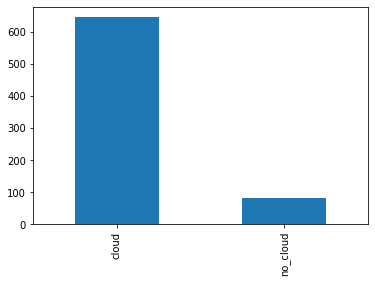

In [33]:
# plot distrobution
fig, ax = plt.subplots()
preds_gdf['pred_class'].value_counts().plot(ax=ax, kind='bar')

In [34]:
# export vector file
preds_gdf.to_file(export_vector_path, driver="GPKG")